
This is an interactive tutorial designed to walk you through the steps of
fitting an autoregressive Poisson GLM (i.e., a spiking GLM with
spike-history) and a multivariate autoregressive Poisson GLM (i.e., a
GLM with spike-history AND coupling between neurons).

Data: from Uzzell & Chichilnisky 2004; see README file for details. 

Last updated: Mar 10, 2020 (JW Pillow)

Instructions: Execute each section below separately using cmd-enter.
For detailed suggestions on how to interact with this tutorial, see
header material in tutorial1_PoissonGLM.m

Transferred into python by Xiaodong LI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import hankel,pinv
from scipy.interpolate import interp1d
from interpolation import interp
from numpy.linalg import inv,norm,lstsq
from matplotlib import mlab
aa=np.asarray

# Load raw data

Be sure to unzip the data file data_RGCs.zip
(http://pillowlab.princeton.edu/data/data_RGCs.zip) and place it in 
this directory before running the tutorial.  
Or substitute your own dataset here instead!


(Data from Uzzell & Chichilnisky 2004):

In [2]:
datadir='../data_RGCs/' # directory where stimulus lives
Stim=loadmat(datadir+'Stim.mat')['Stim'].flatten() # stimulus (temporal binary white noise)
stimtimes=loadmat(datadir+'stimtimes.mat')['stimtimes'].flatten() # stim frame times in seconds (if desired)
SpTimes=loadmat(datadir+'SpTimes.mat')['SpTimes'][0,:] # load spike times (in units of stim frames)
SpTimes=[p.flatten() for p in SpTimes]
ncells=len(SpTimes)

Compute some basic statistics on the stimulus

In [3]:
dtStim = stimtimes[1]-stimtimes[0] # time bin size for stimulus (s)
nT = Stim.shape[0] # number of time bins in stimulus
# See tutorial 1 for some code to visualize the raw data!

# Bin the spike trains

For now we will assume we want to use the same time bin size as the time bins used for the stimulus. Later, though, we'll wish to vary this.

In [4]:
tbins=np.arange(.5,nT+1.5)*dtStim # time bin centers for spike train binning
sps=np.zeros([nT,ncells])

for jj in range(ncells):
    sps[:,jj]=np.histogram(SpTimes[jj],tbins)[0] # binned spike train

Let's just visualize the spike-train auto and cross-correlations (Comment out this part if desired!)

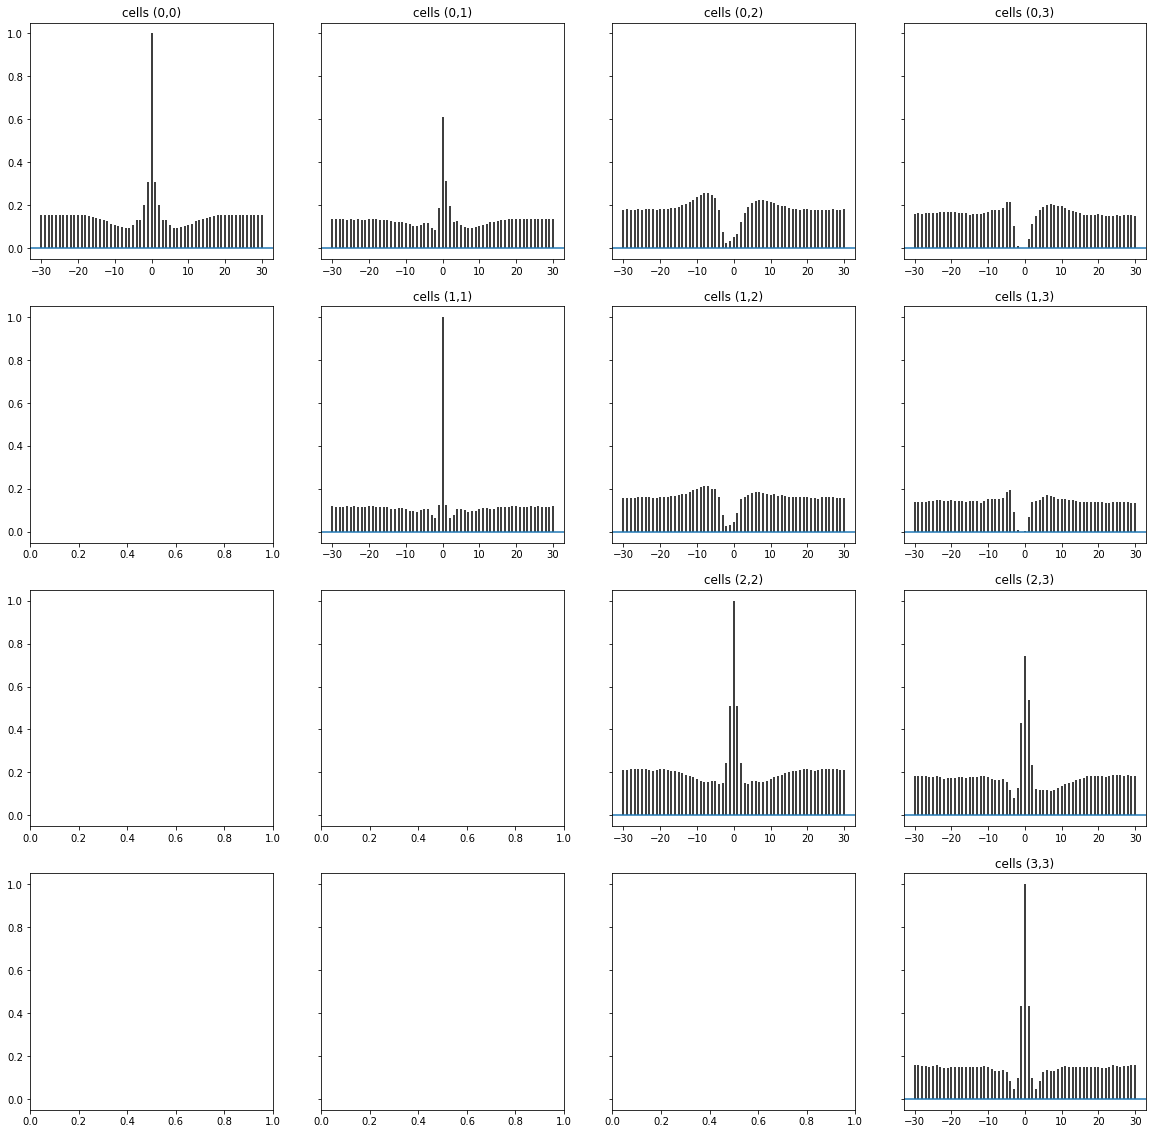

In [65]:
nlags=30 # number of time-lags to use

fig,axes=plt.subplots(nrows=ncells,ncols=ncells,figsize=(20,20),sharey=True)
for ii in range(ncells):
    for jj in range(ii,ncells):
        # Compute cross-correlation of neuron i with neuron j
        axes[ii,jj].xcorr(sps[:,ii],sps[:,jj],maxlags=nlags,normed=True)
        axes[ii,jj].set_title('cells (%d,%d)'%(ii,jj))

# Build design matrix: single-neuron GLM with spike-history

Pick the cell to focus on (for now).

In [6]:
cellnum = 2  # 0-1: OFF, 2-3: ON

Set the number of time bins of stimulus to use for predicting spikes

In [7]:
ntfilt = 25 # Try varying this, to see how performance changes!

Set number of time bins of auto-regressive spike-history to use

In [8]:
nthist = 20

Build stimulus design matrix (using `hankel`)

In [9]:
paddedStim=np.r_[np.zeros(ntfilt-1),Stim] # pad early bins of stimulus with zero
Xstim=hankel(paddedStim[:-ntfilt+1],Stim[-ntfilt:])

Build spike-history design matrix

In [10]:
paddedSps=np.r_[np.zeros(nthist),sps[:-1,cellnum]]

SUPER important: note that this doesn't include the spike count for the
bin we're predicting? The spike train is shifted by one bin (back in
time) relative to the stimulus design matrix

In [11]:
Xsp = hankel(paddedSps[:-nthist+1], paddedSps[-nthist:])

Combine these into a single design matrix

In [12]:
Xdsgn=np.c_[Xstim,Xsp] # post-spike here `Xsp`

Let's visualize the design matrix just to see what it looks like

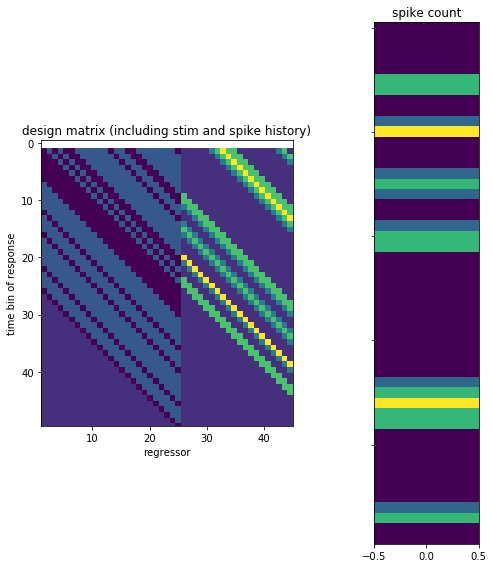

In [18]:
fig,axes=plt.subplots(ncols=2,sharey=True,figsize=(8,8))
axes[0].imshow(Xdsgn[:50,:],extent=[1,ntfilt+nthist,1,50],aspect=1)
axes[0].set_xlabel('regressor')
axes[0].set_ylabel('time bin of response')
axes[0].set_title('design matrix (including stim and spike history)')

axes[1].imshow(sps[:50,cellnum].reshape(-1,1),aspect=0.1)
axes[1].set_title('spike count')
fig.tight_layout()

The left part of the design matrix has the stimulus values, the right part has the spike-history values.  The image on the right is the spike count to be predicted.  Note that the spike-history portion of the design matrix had better be shifted so that we aren't allowed to use the spike count on this time bin to predict itself!

# Fit single-neuron GLM with spike-history

First fit GLM with no spike-history

In [19]:
import statsmodels.api as sm

In [21]:
print('Now fitting basic Poisson GLM...\n')
glmModel=sm.GLM(sps[:,cellnum],sm.add_constant(Xstim),family=sm.families.Poisson()).fit()
pGLMwts0=glmModel.params
pGLMconst0=pGLMwts0[0]
pGLMfilt0=pGLMwts0[1:]

Now fitting basic Poisson GLM...



Then fit GLM with spike history (now use Xdsgn design matrix instead of Xstim)

In [23]:
print('Now fitting Poisson GLM with spike-history...\n')
glmModel=sm.GLM(sps[:,cellnum],sm.add_constant(Xdsgn),family=sm.families.Poisson()).fit()
pGLMwts1=glmModel.params
pGLMconst1=pGLMwts1[0]
pGLMfilt1=pGLMwts1[1:1+ntfilt] # stimulus weights
pGLMhistfilt1=pGLMwts1[1+ntfilt:] # spike weights

Now fitting Poisson GLM with spike-history...



Make plots comparing filters

In [24]:
ttk = np.arange(-ntfilt+1,1)*dtStim # time bins for stim filter
tth = np.arange(-nthist,0)*dtStim # time bins for spike-history filter

Text(0.5, 0, 'time before spike (s)')

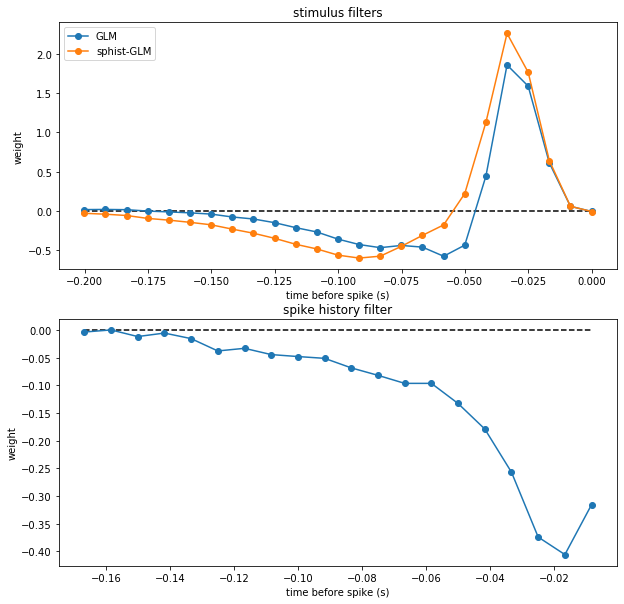

In [53]:
fig,axes=plt.subplots(nrows=2,figsize=(10,10)) 

axes[0].plot(ttk,ttk*0,'k--') # Plot stim filters
axes[0].plot(ttk,pGLMfilt0,'o-',label='GLM')
axes[0].plot(ttk,pGLMfilt1,'o-',label='sphist-GLM')
axes[0].legend()
axes[0].set_title('stimulus filters')
axes[0].set_ylabel('weight')
axes[0].set_xlabel('time before spike (s)')

axes[1].plot(tth,tth*0,'k--') # Plot spike history filter
axes[1].plot(tth,pGLMhistfilt1,'o-')
axes[1].set_title('spike history filter')
axes[1].set_ylabel('weight')
axes[1].set_xlabel('time before spike (s)')

# Plot predicted rate out of the two models

Compute predicted spike rate on training data

In [26]:
ratepred0=np.exp(pGLMconst0+Xstim@pGLMfilt0) # take stim weights to predict spike count
ratepred1=np.exp(pGLMconst0+Xdsgn@pGLMwts1[1:]) # take history spike weights to predict spike count

Make plot

<ipython-input-57-4b5f70e8ea47>:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem(ttplot,sps[iiplot,cellnum],'k',label='spikes')


Text(0.5, 1.0, 'spikes and rate predictions')

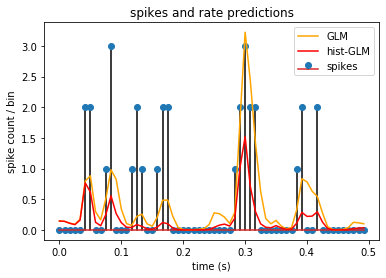

In [57]:
iiplot=np.arange(60)
ttplot=iiplot*dtStim

fig,axes=plt.subplots()

axes.stem(ttplot,sps[iiplot,cellnum],'k',label='spikes')
axes.plot(ttplot,ratepred0[iiplot],color='orange',label='GLM')
axes.plot(ttplot,ratepred1[iiplot],color='red',label='hist-GLM')


axes.legend()
axes.set_xlabel('time (s)')
axes.set_ylabel('spike count / bin')
axes.set_title('spikes and rate predictions')

# Fit coupled GLM for multiple-neuron responses

First step: build design matrix containing spike history for all neurons

In [34]:
Xspall=np.zeros([nT,nthist,ncells]) # allocate space

Loop over neurons to build design matrix, exactly as above

In [35]:
for jj in range(ncells):
    paddedSps=np.r_[np.zeros(nthist),sps[:-1,jj]]
    Xspall[:,:,jj]=hankel(paddedSps[:-nthist+1],paddedSps[-nthist:])

Reshape it to be a single matrix

In [36]:
Xspall=Xspall.reshape(Xspall.shape[0],np.prod(Xspall.shape[1:]))
Xdsgn2=np.c_[Xstim,Xspall] # full design matrix (with all 4 neuron spike hist)

Let's visualize 50 time bins of full design matrix

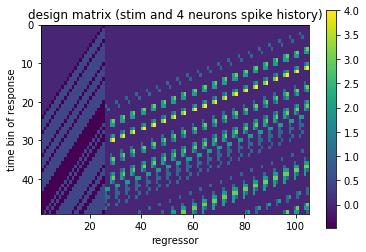

In [55]:
fig,axes=plt.subplots()
im=axes.imshow(Xdsgn2[:50,:],extent=[1,ntfilt+nthist*ncells,49,0],aspect=1.5)
axes.set_title('design matrix (stim and 4 neurons spike history)')
axes.set_xlabel('regressor')
axes.set_ylabel('time bin of response')
fig.colorbar(im)

## Fit the model (stim filter, sphist filter, coupling filters) for one neuron

In [41]:
print('Now fitting Poisson GLM with spike-history and coupling...\n')

glmModel=sm.GLM(sps[:,cellnum],sm.add_constant(Xdsgn2),family=sm.families.Poisson()).fit()
pGLMwts2=glmModel.params
pGLMconst2=pGLMwts2[0]
pGLMfilt2=pGLMwts2[1:1+ntfilt]
pGLMhistfilt2=pGLMwts2[1+ntfilt:]
pGLMhistfilt2=pGLMhistfilt2.reshape(nthist,ncells) # coupled

Now fitting Poisson GLM with spike-history and coupling...



So far all we've done is fit incoming stimulus and coupling filters for
one neuron.  To fit a full population model, redo the above for each cell
(i.e., to get incoming filters for 'cellnum' = 1, 2, 3, and 4 in turn).

## Plot the fitted filters and rate prediction

Text(0.5, 0, 'time before spike (s)')

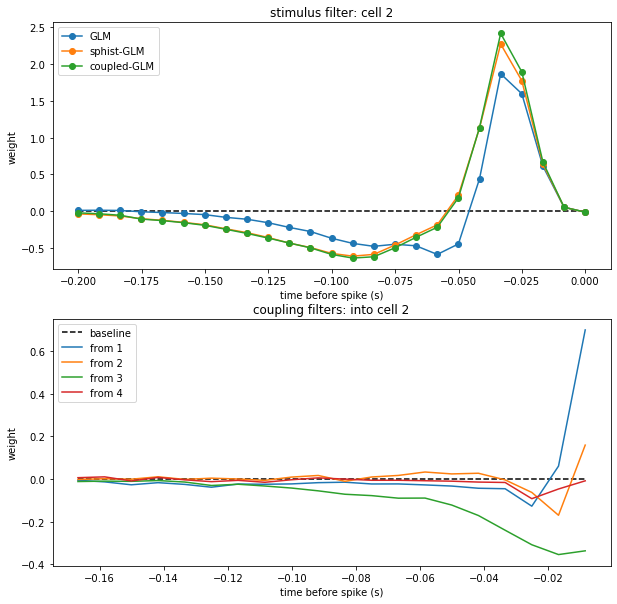

In [60]:
fig,axes=plt.subplots(nrows=2,figsize=(10,10)) 

axes[0].plot(ttk,ttk*0,'k--') # Plot stim filters
axes[0].plot(ttk,pGLMfilt0,'o-',label='GLM')
axes[0].plot(ttk,pGLMfilt1,'o-',label='sphist-GLM')
axes[0].plot(ttk,pGLMfilt2,'o-',label='coupled-GLM')
axes[0].legend()
axes[0].set_title('stimulus filter: cell %d'%cellnum)
axes[0].set_ylabel('weight')
axes[0].set_xlabel('time before spike (s)')

axes[1].plot(tth,tth*0,'k--') # Plot spike history filter
axes[1].plot(tth,pGLMhistfilt2)
axes[1].legend(['baseline','from 1','from 2','from 3','from 4'])
axes[1].set_title('coupling filters: into cell %d'%cellnum)
axes[1].set_ylabel('weight')
axes[1].set_xlabel('time before spike (s)')

Compute predicted spike rate on training data

In [61]:
ratepred2 = np.exp(pGLMconst2 + Xdsgn2@pGLMwts2[1:])

Make plot

<ipython-input-62-ae2c18ad6a2e>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem(ttplot,sps[iiplot,cellnum],'k')


Text(0.5, 1.0, 'spikes and rate predictions')

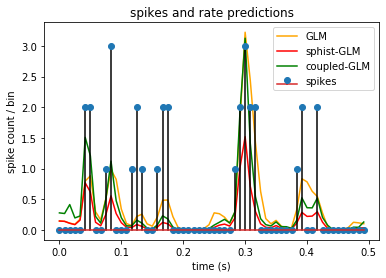

In [62]:
iiplot = np.arange(60)
ttplot = iiplot*dtStim

fig,axes=plt.subplots()

axes.plot(ttplot,ratepred0[iiplot],color='orange')
axes.plot(ttplot,ratepred1[iiplot],color='red')
axes.plot(ttplot,ratepred2[iiplot],color='green')
axes.stem(ttplot,sps[iiplot,cellnum],'k')
axes.legend(['GLM','sphist-GLM','coupled-GLM','spikes'])
axes.set_xlabel('time (s)')
axes.set_ylabel('spike count / bin')
axes.set_title('spikes and rate predictions')

# Model comparison: log-likelihoood and AIC

Let's compute loglikelihood (single-spike information) and AIC to see how much we gain by adding each of these filter types in turn:

[GLM Poisson model logliklihood](https://en.wikipedia.org/wiki/Poisson_regression#:~:text=A%20Poisson%20regression%20model%20is%20sometimes%20known%20as,to%20the%20mean%20made%20by%20the%20Poisson%20model.)

In [47]:
LL_stimGLM = sps[:,cellnum].T@np.log(ratepred0) - np.sum(ratepred0) # already logarithmic
LL_histGLM = sps[:,cellnum].T@np.log(ratepred1) - np.sum(ratepred1)
LL_coupledGLM = sps[:,cellnum].T@np.log(ratepred2) - np.sum(ratepred2)

log-likelihood for homogeneous Poisson model

In [48]:
nsp = np.sum(sps[:,cellnum])
ratepred_const = nsp/nT # mean number of spikes / bin
LL0 = nsp*np.log(ratepred_const) - nT*np.sum(ratepred_const)

Report single-spike information (bits / sp)

In [49]:
SSinfo_stimGLM = (LL_stimGLM - LL0)/nsp/np.log(2)
SSinfo_histGLM = (LL_histGLM - LL0)/nsp/np.log(2)
SSinfo_coupledGLM = (LL_coupledGLM - LL0)/nsp/np.log(2)

In [64]:
print('\n empirical single-spike information:\n ---------------------- ')
print('stim-GLM: %.2f bits/sp'%SSinfo_stimGLM)
print('hist-GLM: %.2f bits/sp'%SSinfo_histGLM)
print('coupled-GLM: %.2f bits/sp'%SSinfo_coupledGLM)


 empirical single-spike information:
 ---------------------- 
stim-GLM: 1.09 bits/sp
hist-GLM: 0.92 bits/sp
coupled-GLM: 1.19 bits/sp


Compute [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

Let $k$ be the number of estimated parameters in the model. Let $\hat{L}$ be the maximum value of the likelihood function for the model. Then the AIC value of the model is the following.

$$\mathrm {AIC} =2k-2\ln({\hat {L}})$$

Given a set of cand

In [51]:
AIC0 = -2*LL_stimGLM + 2*(1+ntfilt)
AIC1 = -2*LL_histGLM + 2*(1+ntfilt+nthist)
AIC2 = -2*LL_coupledGLM + 2*(1+ntfilt+ncells*nthist)
AICmin = min(AIC0,AIC1,AIC2) # the minimum of these

In [67]:
print('\n AIC comparison (smaller is better):\n ---------------------- \n')
print('stim-GLM: %.1f'%(AIC0-AICmin))
print('hist-GLM: %.1f'%(AIC1-AICmin))
print('coupled-GLM: %.1f'%(AIC2-AICmin))


 AIC comparison (smaller is better):
 ---------------------- 

stim-GLM: 6870.5
hist-GLM: 18601.2
coupled-GLM: 0.0


These are whopping differencess! Clearly coupling has a big impact in
terms of log-likelihood, though the jump from stimulus-only to
own-spike-history is greater than the jump from spike-history to
full coupling.

Advanced exercises:
--------------------

1. Write code to simulate spike trains from the fitted spike-history GLM.
Simulate a raster of repeated responses from the stim-only GLM and
compare to raster from the spike-history GLM

2. Write code to simulate the 4-neuron population-coupled GLM. There are
now 16 spike-coupling filters (including self-coupling), since each
neuron has 4 incoming coupling filters (its own spike history coupling
filter plus coupling from three other neurons.  How does a raster of
responses from this model compare to the two single-neuron models?

3. Compute a non-parametric estimate of the spiking nonlinearity for each
neuron. How close does it look to exponential now that we have added
spike history? Rerun your simulations using different non-parametric
nonlinearity for each neuron. How much improvement do you see in terms of
log-likelihood, AIC, or PSTH variance accounted for (R^2) when you
simulate repeated responses?
